In [2]:
import numpy as np

from vehicle2d import *
from sensor import *
from ekf import *

import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

In [17]:
#initialise state
init_speed = 2
init_x = np.random.randn()
init_y = np.random.randn()
init_psi = np.random.uniform(low = np.deg2rad(-180), high = np.deg2rad(180))
#init_psi = np.deg2rad(45)

print(f"init_x: {init_x}, init_y: {init_y}, init_psi: {np.rad2deg(init_psi)}")

#initialise time setting
dt = 0.01
end_time = 200

#initialise measurement setting
gps_meas_rate = 1
lidar_measurement_rate = 10

#initialise sensor noise standard deviation
gyro_std = np.deg2rad(0.01)
gps_pos_std = 3.

lidar_range_std = 3.0
lidar_theta_std = 0.02

beacon_num = 2000

#initialise simulation step
sim_steps = np.ceil(end_time/dt).astype(int)
gps_meas_steps = np.ceil(1/gps_meas_rate/dt).astype(int)
lidar_meas_steps = np.ceil(1/lidar_measurement_rate/dt).astype(int)

#initialise vehicle model
vehicle_model = vehicle2d()
vehicle_model.init_state(init_x, init_y, init_psi, init_speed)

#initialise gps sensor
gps = gps_sensor()

#initialise lidar sensor
lidar = lidar_sensor()

#initialise beacon points
beacon_list = [] 
bx = np.random.uniform(low = -400, high = 400, size = beacon_num)
by = np.random.uniform(low = -400, high = 400, size = beacon_num)
for i in range(beacon_num):
    b = beacon_point()
    b.x = bx[i]
    b.y = by[i]
    beacon_list.append(b)

#initialise kalman filter
kf_model = ekf(init_vel_std = 3,
               init_psi_std = np.deg2rad(45),
               acc_std = 0.1, 
               gyro_std = gyro_std, 
               gps_pos_std = gps_pos_std,
               lidar_range_std = lidar_range_std, 
               lidar_theta_std = lidar_theta_std,
               gps_meas_rate=gps_meas_rate)

#initialise innovation history
inno_hist = []

#initialise estimation error history
est_err_hist = []

#initialise kf estimated state history
kf_state_hist = []

#initialise true state history
true_state_hist = []

#initialise gps history
gps_history = []

#initialise state history
state_history = []

#initialise beacon location history
beacon_loc_history = []
is_gen_beacon = False

motion_type = None
curve_type = None
motion_cnt = 0

init_x: -0.5102714075364632, init_y: -0.4213136509338374, init_psi: -112.05084889516974


In [18]:
for i in range(1, sim_steps + 1):

    acc = 0. 

    if motion_type is None:
        motion_type = np.random.binomial(1, 0.5, 1)[0]
        curve_type = np.random.binomial(1, 0.5, 1)[0]

    if  motion_type == 0:
        if curve_type == 0:
            psi_dot = np.deg2rad( 3)
        else:
            psi_dot = np.deg2rad(-3)
    else:
        psi_dot = np.deg2rad(0)

    motion_cnt += 1

    if motion_cnt > 2000:
        motion_cnt = 0
        motion_type = None
        curve_type = None

    vehicle_model.update(dt, acc, psi_dot)
    state = vehicle_model.get_state()

    true_state_hist.append(state)

    #assume measurement rate of gyroscope is the same as simulation rate
    meas_psi_dot = psi_dot + np.random.normal(loc = 0, scale = gyro_std)

    #prediction based on gyroscope
    kf_model.prediction_step(psi_dot = meas_psi_dot, dt = dt)

    #gps measurement
    gps_measurement = None
    if (i % gps_meas_steps) == 0:
        gps.x = state[0, 0] + np.random.normal(loc = 0, scale = gps_pos_std)
        gps.y = state[1, 0] + np.random.normal(loc = 0, scale = gps_pos_std)

        gps_measurement = [gps.x, gps.y]
        kf_model.gps_update_step(gps)
    gps_history.append(gps_measurement)

    #lidar measurement
    detected_beacon = [] 
    if (i % lidar_meas_steps) == 0:
        for b in beacon_list:  
            dx, dy = b.x - state[0, 0], b.y - state[1, 0]
            beacon_range = np.sqrt(dx**2 + dy**2)
            if beacon_range > lidar.max_range:
                continue

            beacon_theta = wrap_ang(np.arctan2(dy, dx) - state[2, 0]) 
            detected_beacon.append([b.x, b.y])

            lidar.range = beacon_range + np.random.normal(loc = 0, scale = lidar_range_std)
            lidar.theta = wrap_ang(beacon_theta + np.random.normal(loc = 0, scale = lidar_theta_std))

            kf_model.lidar_update_step(lidar, b)    
    
    beacon_loc_history.append(detected_beacon)

    est_state = kf_model.get_state() 

    if est_state is not None:
        state_diff = (est_state - state)[:, 0]
        state_diff[2] = wrap_ang(state_diff[2])
        est_err_hist.append(state_diff)
    kf_state_hist.append(est_state)

est_err_hist = np.array(est_err_hist)


initialise kalman filter!
correct gps data
correct gps data
correct gps data
1.7533208048013167
correct gps data
1.982421327800906
correct gps data
2.080170242209091
correct gps data
2.0544470248259756
correct gps data
2.0382393621961894
correct gps data
2.0858129966072276
correct gps data
2.004945102665862
correct gps data
1.9379664195753556
correct gps data
1.8866060534761808
correct gps data
1.9962642850786727
correct gps data
2.048940667013318
correct gps data
2.0467756735913745
correct gps data
2.067474301393247
correct gps data
2.0575065738114393
correct gps data
1.9982742671605878
correct gps data
1.9803447926593012
correct gps data
2.0267679962499585
correct gps data
1.9956142033602045
faulty gps data
correct gps data
correct gps data
1.9625056358169088
correct gps data
1.9944590035186018
correct gps data
2.0196812039747325
correct gps data
1.9959856344697156
correct gps data
2.0225306867465935
correct gps data
2.0360684450735906
correct gps data
2.0126325798455893
correct gps 

i: 9 => 4


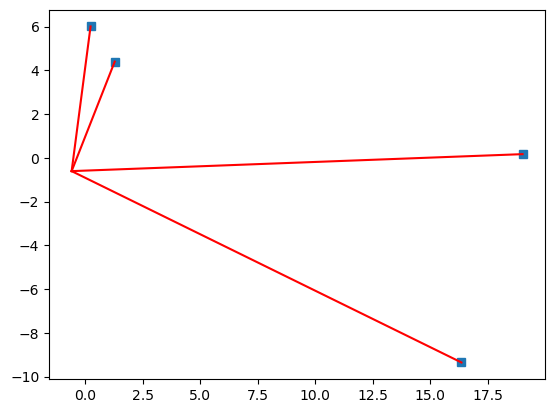

In [24]:
fig2 = plt.figure()
ax2 = plt.subplot(1, 1, 1)

for i in range(len(beacon_loc_history)):
    ax2.clear()
    #plot beacon location
    if len(beacon_loc_history[i]) > 0:
        b = np.array(beacon_loc_history[i])
        ax2.plot(b[:, 0], b[:, 1], 's')
        print(f'i: {i} => {len(b)}')
        #plot linkage between robot and beacon
        for k in range(len(b)):
            x = [true_state_hist[i][0, 0], b[k, 0]]
            y = [true_state_hist[i][1, 0], b[k, 1]]
            ax2.plot(x, y, 'r-')
    plt.plot()

    if i == 9:
        break

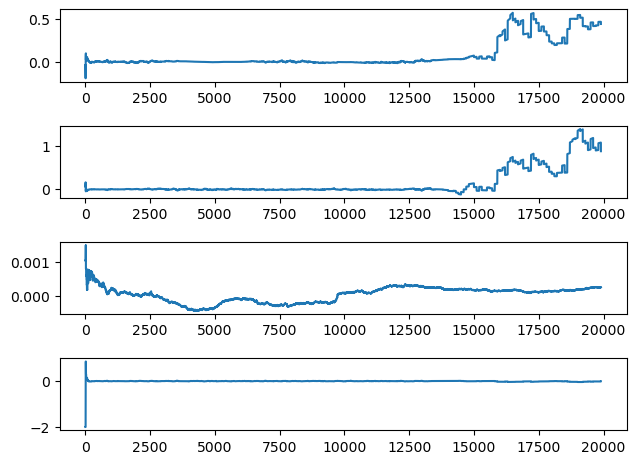

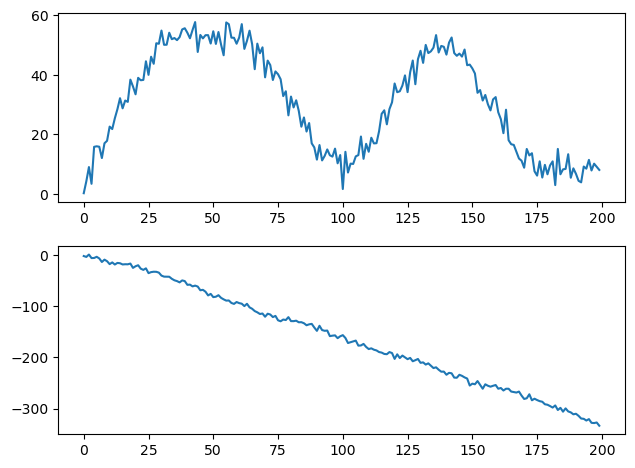

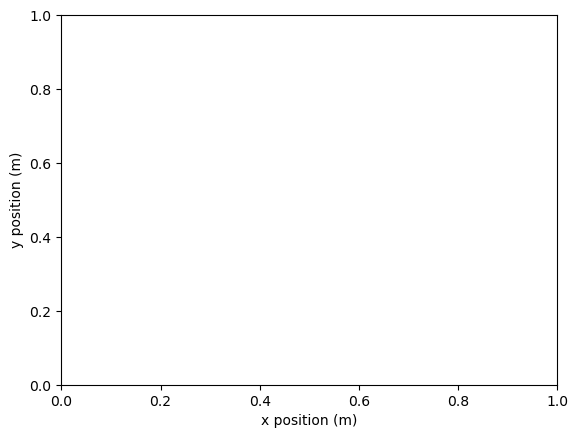

In [10]:
fig, ax = plt.subplots(4)
fig.tight_layout()
for i in range(est_err_hist.shape[1]):
    ax[i].plot(est_err_hist[:, i])

fig3, ax3 = plt.subplots(2)
fig3.tight_layout()

gps_data = np.array([g for g in gps_history if g is not None])
ax3[0].plot(gps_data[:, 0])
ax3[1].plot(gps_data[:, 1])

fig2 = plt.figure()
ax2 = plt.subplot(1, 1, 1)

def init_func():
    ax2.clear()
    plt.xlabel('x position (m)')
    plt.ylabel('y position (m)')

def update_plot(i):

    #clear plot
    ax2.clear()

    #plot true position
    ax2.plot(true_state_hist[i][0,0], true_state_hist[i][1,0], 'og')

    #plot estimate position
    if kf_state_hist[i] is not None:
        ax2.plot(kf_state_hist[i][0,0], kf_state_hist[i][1,0], 'or')

    #plot gps data
    gps_data = np.array([m for m in gps_history[0:i+1] if m is not None])
    if gps_data is not None and len(gps_data) > 0:
        ax2.plot(gps_data[:, 0], gps_data[:, 1], '+k')

    #plot beacon location
    if len(beacon_loc_history[i]) > 0:
        b = np.array(beacon_loc_history[i])
        ax2.plot(b[:, 0], b[:, 1], 's')

        #plot linkage between robot and beacon
        for k in range(len(b)):
            x = [true_state_hist[i][0, 0], b[k, 0]]
            y = [true_state_hist[i][1, 0], b[k, 1]]
            ax2.plot(x, y, 'r-')

    ax2.set_xlim([true_state_hist[i][0, 0] - 30., true_state_hist[i][0, 0] + 30.])
    ax2.set_ylim([true_state_hist[i][1, 0] - 30., true_state_hist[i][1, 0] + 30.])

anim = FuncAnimation(fig2, 
                     update_plot,
                     frames = np.arange(0, sim_steps, 10), 
                     init_func = init_func,
                     interval = 1,
                     repeat = False)

plt.show()